In [1]:
import sys
sys.path.append('../../astro_tools')
sys.path.append('../')
import axes_offset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube
from scipy.integrate import quad


# set up the plot
import cmasher as cmr
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 25,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the standard normal distribution function (PDF)
def gaussian(x, amp, mean, sig):
    return amp * (1 / (sig * np.sqrt(2 * np.pi))) * np.exp(-((x - mean)**2) / (2 * sig**2))


# def get_fluxes(amp,mean,sig,lower_lim, upper_lim):

#     # numerical integration using Gaussian quadrature
#     fluxes, _ = quad(gaussian, lower_limit, upper_limit, args=(amp,mean,sig))

#     return fluxes

def line_flux(amp, sig):
    
    """
    
    Adopted from https://lukeholden.com/blog/measuring_emission_line_fluxes_python.html#measuring_line_fluxes
    
    """
    
    sig_Ang = (sig * 2.2) / 100
    
    flux = amp * sig_Ang * np.sqrt(2*np.pi)
#     flux_err = flux*np.sqrt((peak_err/peak)**2 + (width_err/width)**2)
    return flux


def get_data(line,param,comp):
    
    """
    line must be ha, niia, niib, siia, or siib
    param must be amp, vel, or sigma
    comp must be outflow_blue, outflow_red, or disk
    
    """
    
    file = '../../ngc253/muse/data/output_maps/NW/ngc253_muse_nw_%s_%s_%s.fits' % (line, param, comp)
    
    hdu = fits.open(file)
    hdu_data = hdu[0].data
    
    return(hdu_data)


def make_plots(outb_dat, outr_dat, disk_dat, vmin, vmax, line_label, cbar_label, extent):
        
    cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

    # BLUESHIFTED OUTFLOW
    im = ax1.imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    ax1.set_title('Outflow B', fontsize=24)
    ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
    ax1.set_facecolor('black')
    ax1.set_ylabel('Dec. Offset from \n%s (arcsec)' % dec_dms, fontsize=20)
    ax1.set_yticks([-40, -20, 0, 20, 40])
    
    # add label that this is the NW side of the outflow
    at = AnchoredText('NW', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax1.add_artist(at)

    # REDSHIFTED OUTFLOW
    im = ax2.imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    ax2.set_title('Outflow R', fontsize=24)
    ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
    ax2.set_facecolor('black')
    
    # add label that this is the NW side of the outflow
    at = AnchoredText('NW', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax2.add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax2.add_artist(at)

    # DISK
    im = ax3.imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    ax3.set_title('Disk', fontsize=24)
    ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
    ax3.set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax3.add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax3.add_artist(at)

    cax = ax3.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=ax3, cax=cax)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

    fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=20, family='courier new', weight='bold', style='normal')
    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.3, hspace=0)
    plt.show()
    
    return


def make_big_plot(axNums, outb_dat, outr_dat, disk_dat, vmin, vmax, 
                  titles, line_label, cbar_label, extent, 
                  alpha_outb='None', alpha_outr='None', alpha_disk='None'):
        
    cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
    cmap_alpha = cmr.get_sub_cmap('gist_gray_r', 0.0, 0.5)
#     cmap_alpha = cmr.get_sub_cmap('gist_gray', 0.5, 0.9)
    
    # BLUESHIFTED OUTFLOW
    im = axNums[0].imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_outb) != str:
        gray_outb = np.zeros_like(outb_dat)
        gray_outb[~np.isfinite(outb_dat)] = np.nan
        axNums[0].imshow(gray_outb, origin='lower',cmap=cmap_alpha, alpha=alpha_outb,extent=extent)
    
    axNums[0].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[0].set_facecolor('black')
    axNums[0].set_yticks([-40, -20, 0, 20, 40])
    
    # add label that this is the NW side of the outflow
    at = AnchoredText('NW', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[0].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[0].add_artist(at)
      
    # add a title to the subplot
    if titles == True:
        axNums[0].set_title('Outflow B', fontsize=26)

    # REDSHIFTED OUTFLOW
    im = axNums[1].imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_outr) != str:
        gray_outr = np.zeros_like(outr_dat)
        gray_outr[~np.isfinite(outr_dat)] = np.nan
        axNums[1].imshow(gray_outr, origin='lower',cmap=cmap_alpha, alpha=alpha_outr,extent=extent)
    
    axNums[1].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[1].set_facecolor('black')
    
    # add label that this is the NW side of the outflow
    at = AnchoredText('NW', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[1].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[1].add_artist(at)
        
    if titles == True:
        axNums[1].set_title('Outflow R', fontsize=26)

    # DISK
    im = axNums[2].imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_disk) != str:
        gray_disk = np.zeros_like(disk_dat)
        gray_disk[~np.isfinite(disk_dat)] = np.nan
        axNums[2].imshow(gray_disk, origin='lower',cmap=cmap_alpha, alpha=alpha_disk,extent=extent)
    
    axNums[2].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[2].set_facecolor('black')
    
    # add label that this is the NW side of the outflow
    at = AnchoredText('NW', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[2].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[2].add_artist(at)
        
    if titles == True:
        axNums[2].set_title('Disk', fontsize=26)

    cax = axNums[2].inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=axNums[2], cax=cax)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=18, length=7, direction='in')
    
    return


def make_big_plot_diff_axes(axNums, outb_dat, outr_dat, disk_dat, vmin, vmax, 
                  titles, line_label, cbar_label, extent, extent_label,
                           alpha_outb='None', alpha_outr='None', alpha_disk='None'):
        
    cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
    cmap_alpha = cmr.get_sub_cmap('gist_gray_r', 0.0, 0.5)
    
    # BLUESHIFTED OUTFLOW
    axNums[0].get_shared_x_axes().join(axNums[0], axNums[1], axNums[2])
    axNums[0].get_shared_y_axes().join(axNums[0], axNums[1], axNums[2])
    
    im = axNums[0].imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_outb) != str:
        gray_outb = np.zeros_like(outb_dat)
        gray_outb[~np.isfinite(outb_dat)] = np.nan
        axNums[0].imshow(gray_outb, origin='lower',cmap=cmap_alpha, alpha=alpha_outb,extent=extent)
    
    axNums[0].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[0].set_facecolor('black')
    axNums[0].set_yticks(extent_label)
    axNums[0].set_xticks(extent_label)
    
    # add label that this is the NW side of the outflow
    at = AnchoredText('NW', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[0].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[0].add_artist(at)
      
    # add a title to the subplot
    if titles == True:
        axNums[0].set_title('Outflow B', fontsize=26)

    # REDSHIFTED OUTFLOW
    im = axNums[1].imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_outr) != str:
        gray_outr = np.zeros_like(outr_dat)
        gray_outr[~np.isfinite(outr_dat)] = np.nan
        axNums[1].imshow(gray_outr, origin='lower',cmap=cmap_alpha, alpha=alpha_outr,extent=extent)
    
    axNums[1].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[1].set_facecolor('black')
    axNums[1].set_yticks(extent_label)
    axNums[1].set_yticklabels([])
    axNums[1].set_xticks(extent_label)
    
    # add label that this is the NW side of the outflow
    at = AnchoredText('NW', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[1].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[1].add_artist(at)
        
    if titles == True:
        axNums[1].set_title('Outflow R', fontsize=26)

    # DISK
    im = axNums[2].imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_disk) != str:
        gray_disk = np.zeros_like(disk_dat)
        gray_disk[~np.isfinite(disk_dat)] = np.nan
        axNums[2].imshow(gray_disk, origin='lower',cmap=cmap_alpha, alpha=alpha_disk,extent=extent)
    
    axNums[2].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[2].set_facecolor('black')
    axNums[2].set_yticks(extent_label)
    axNums[2].set_yticklabels([])
    axNums[2].set_xticks(extent_label)
    
    # add label that this is the NW side of the outflow
    at = AnchoredText('NW', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[2].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[2].add_artist(at)
        
    if titles == True:
        axNums[2].set_title('Disk', fontsize=26)

    cax = axNums[2].inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=axNums[2], cax=cax)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=18, length=7, direction='in')
    
    return


def equiv_width(amp, cont):
    
    return(amp/cont)

In [3]:
# grab files, including the original
# get info of original data
og = '../../ngc253/muse/data/ADP.2019-08-24T09_53_08.548.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
y, x = og_data[1].shape
w = wcs.WCS(hdu.header, naxis=2).celestial

ha_amp_disk = get_data(line='ha', param='amp', comp='disk')
ha_vel_disk = get_data(line='ha', param='vel', comp='disk')
ha_sig_disk = get_data(line='ha', param='sig', comp='disk')
ha_amp_outb = get_data(line='ha', param='amp', comp='outflow_blue')
ha_vel_outb = get_data(line='ha', param='vel', comp='outflow_blue')
ha_sig_outb = get_data(line='ha', param='sig', comp='outflow_blue')
ha_amp_outr = get_data(line='ha', param='amp', comp='outflow_red')
ha_vel_outr = get_data(line='ha', param='vel', comp='outflow_red')
ha_sig_outr = get_data(line='ha', param='sig', comp='outflow_red')

niib_amp_disk = get_data(line='niib', param='amp', comp='disk')
niib_vel_disk = get_data(line='niib', param='vel', comp='disk')
niib_sig_disk = get_data(line='niib', param='sig', comp='disk')
niib_amp_outb = get_data(line='niib', param='amp', comp='outflow_blue')
niib_vel_outb = get_data(line='niib', param='vel', comp='outflow_blue')
niib_sig_outb = get_data(line='niib', param='sig', comp='outflow_blue')
niib_amp_outr = get_data(line='niib', param='amp', comp='outflow_red')
niib_vel_outr = get_data(line='niib', param='vel', comp='outflow_red')
niib_sig_outr = get_data(line='niib', param='sig', comp='outflow_red')

siib_amp_disk = get_data(line='siib', param='amp', comp='disk')
siib_vel_disk = get_data(line='siib', param='vel', comp='disk')
siib_sig_disk = get_data(line='siib', param='sig', comp='disk')
siib_amp_outb = get_data(line='siib', param='amp', comp='outflow_blue')
siib_vel_outb = get_data(line='siib', param='vel', comp='outflow_blue')
siib_sig_outb = get_data(line='siib', param='sig', comp='outflow_blue')
siib_amp_outr = get_data(line='siib', param='amp', comp='outflow_red')
siib_vel_outr = get_data(line='siib', param='vel', comp='outflow_red')
siib_sig_outr = get_data(line='siib', param='sig', comp='outflow_red')

siia_amp_disk = get_data(line='siia', param='amp', comp='disk')
siia_vel_disk = get_data(line='siia', param='vel', comp='disk')
siia_sig_disk = get_data(line='siia', param='sig', comp='disk')
siia_amp_outb = get_data(line='siia', param='amp', comp='outflow_blue')
siia_vel_outb = get_data(line='siia', param='vel', comp='outflow_blue')
siia_sig_outb = get_data(line='siia', param='sig', comp='outflow_blue')
siia_amp_outr = get_data(line='siia', param='amp', comp='outflow_red')
siia_vel_outr = get_data(line='siia', param='vel', comp='outflow_red')
siia_sig_outr = get_data(line='siia', param='sig', comp='outflow_red')


# get the signal to noise
rms_infile = '../../ngc253/muse/data/output_maps/NW/ngc253_muse_nw_rms.fits'
hdu_rms = fits.open(rms_infile)
rms = hdu_rms[0].data

SNR_ha_disk = ha_amp_disk / rms
SNR_ha_outb = ha_amp_outb / rms
SNR_ha_outr = ha_amp_outr / rms
SNR_sii_disk = (siia_amp_disk + siib_amp_disk) / rms
SNR_sii_outb = (siia_amp_outb + siib_amp_outb) / rms
SNR_sii_outr = (siia_amp_outr + siib_amp_outr) / rms

# make an alpha layer for the signal to noise
alpha_SNR_ha_disk = np.zeros_like(SNR_ha_disk)
alpha_SNR_ha_disk[SNR_ha_disk < 3.] = 1.
alpha_SNR_ha_outb = np.zeros_like(SNR_ha_outb)
alpha_SNR_ha_outb[SNR_ha_outb < 3.] = 1.
alpha_SNR_ha_outr = np.zeros_like(SNR_ha_outr)
alpha_SNR_ha_outr[SNR_ha_outr < 3.] = 1.

alpha_SNR_sii_disk = np.zeros_like(SNR_sii_disk)
alpha_SNR_sii_disk[SNR_sii_disk < 3.] = 1.
alpha_SNR_sii_outb = np.zeros_like(SNR_sii_outb)
alpha_SNR_sii_outb[SNR_sii_outb < 3.] = 1.
alpha_SNR_sii_outr = np.zeros_like(SNR_sii_outr)
alpha_SNR_sii_outr[SNR_sii_outr < 3.] = 1.

In [4]:
ha_flux_disk = line_flux(ha_amp_disk, ha_sig_disk)
ha_flux_outb = line_flux(ha_amp_outb, ha_sig_outb)
ha_flux_outr = line_flux(ha_amp_outr, ha_sig_outr)

niib_flux_disk = line_flux(niib_amp_disk, niib_sig_disk)
niib_flux_outb = line_flux(niib_amp_outb, niib_sig_outb)
niib_flux_outr = line_flux(niib_amp_outr, niib_sig_outr)

siia_flux_disk = line_flux(siia_amp_disk, siia_sig_disk)
siia_flux_outb = line_flux(siia_amp_outb, siia_sig_outb)
siia_flux_outr = line_flux(siia_amp_outr, siia_sig_outr)

siib_flux_disk = line_flux(siib_amp_disk, siib_sig_disk)
siib_flux_outb = line_flux(siib_amp_outb, siib_sig_outb)
siib_flux_outr = line_flux(siib_amp_outr, siib_sig_outr)

In [5]:
# take ratios
nii_disk_rat = np.log10(niib_flux_disk / ha_flux_disk)
nii_outb_rat = np.log10(niib_flux_outb / ha_flux_outb)
nii_outr_rat = np.log10(niib_flux_outr / ha_flux_outr)

sii_disk_rat = np.log10((siia_flux_disk + siib_flux_disk) / ha_flux_disk)
sii_outb_rat = np.log10((siia_flux_outb + siib_flux_outb) / ha_flux_outb)
sii_outr_rat = np.log10((siia_flux_outr + siib_flux_outr) / ha_flux_outr)

In [6]:
ra_hms, dec_dms = axes_offset.get_offset(ha_amp_disk, w)
pixscale = 0.2  # arcsec
x_lower = -(ha_amp_disk.shape[1]*pixscale)//2
x_upper = (ha_amp_disk.shape[1]*pixscale)//2
y_lower = -(ha_amp_disk.shape[0]*pixscale)//2
y_upper = (ha_amp_disk.shape[0]*pixscale)//2
extent_full=[x_lower,x_upper, y_lower,y_upper]

First plot the integrated fluxes.

In [7]:
# make_plots(np.log(ha_flux_outb * 10**4), 
#            np.log(ha_flux_outr * 10**4), 
#            np.log(ha_flux_disk * 10**4),
#            vmin = 0,
#            vmax = 5,
#            line_label = 'H$\\alpha$', 
#            cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)')

# make_plots(np.log(niib_flux_outb * 10**4), 
#            np.log(niib_flux_outr * 10**4), 
#            np.log(niib_flux_disk * 10**4),
#            vmin = 0,
#            vmax = 5,
#            line_label = '[N II]\n$\lambda6583.45$', 
#            cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)')

# make_plots(np.log((siia_flux_outb+siib_flux_outb) * 10**4), 
#            np.log((siia_flux_outr+siib_flux_outb) * 10**4), 
#            np.log((siia_flux_disk+siib_flux_outb) * 10**4),
#            vmin = 0,
#            vmax = 5,
#            line_label = '[S II]\n$\lambda6716.44+\lambda6730.82$', 
#            cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)')

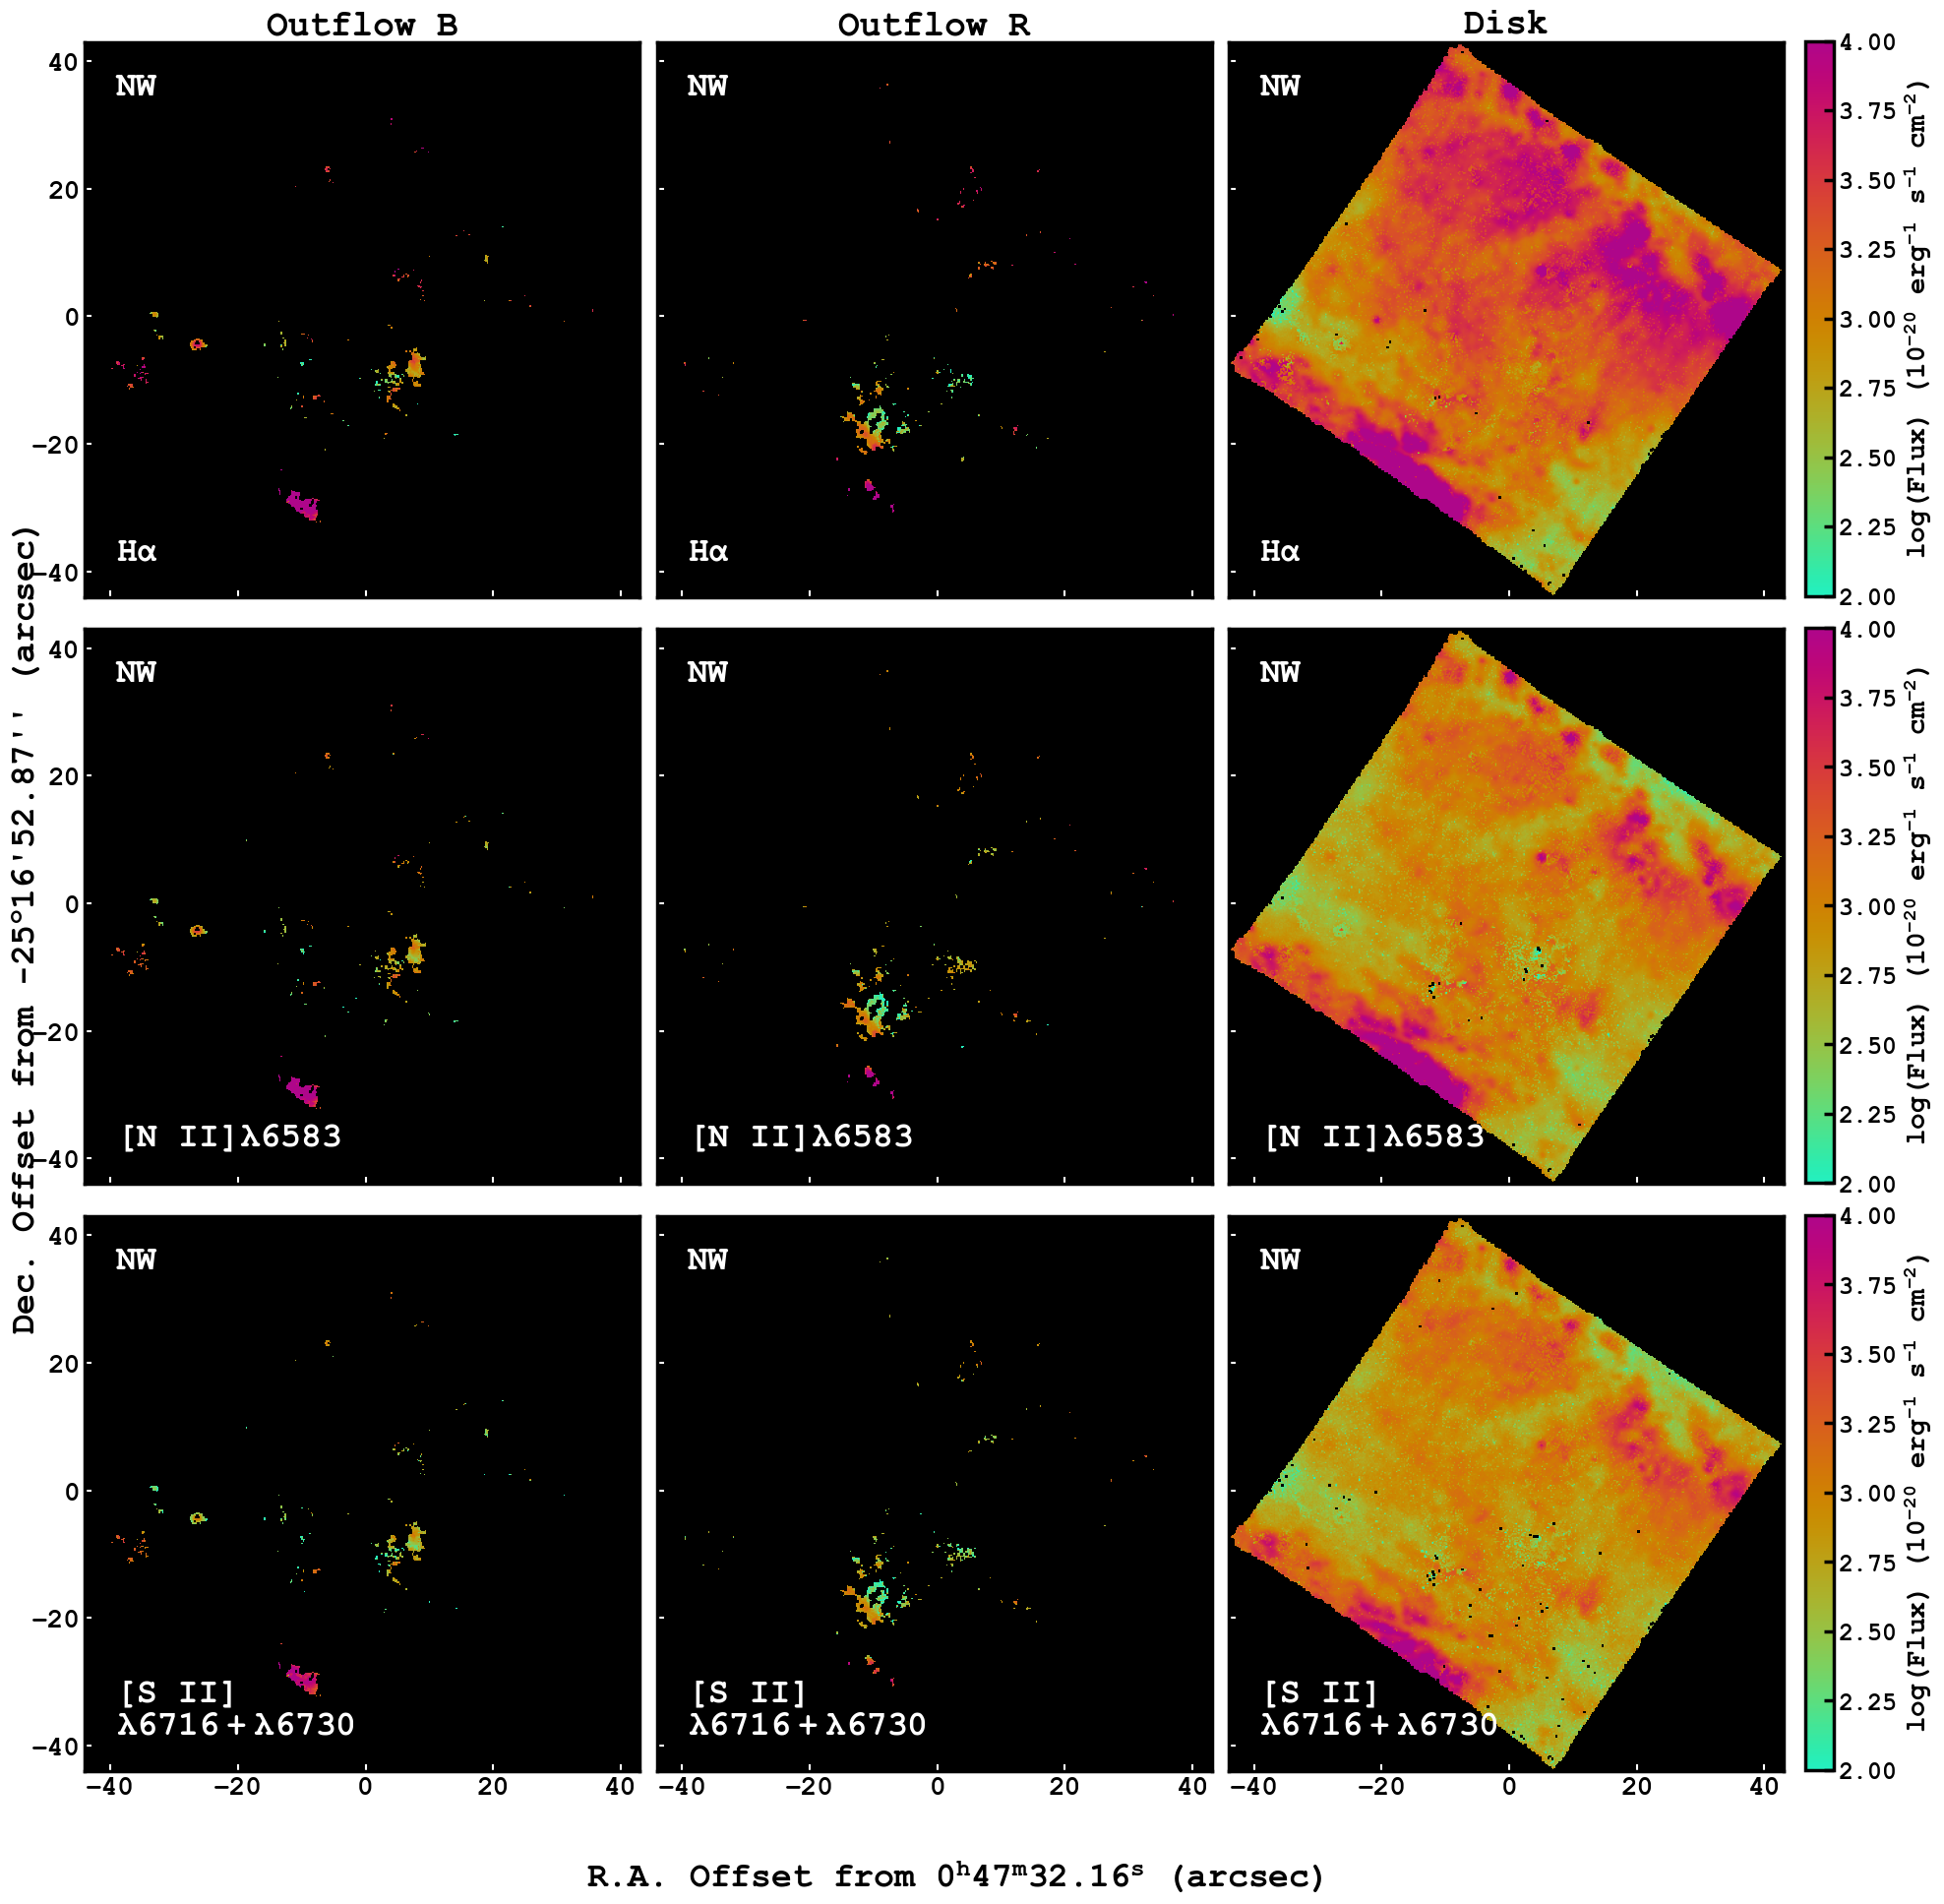

In [8]:
fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6),
     (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

# top row
make_big_plot([ax1, ax2, ax3],
              np.log10(ha_flux_outb),
              np.log10(ha_flux_outr),
              np.log10(ha_flux_disk),
              vmin = 2,
              vmax = 4,
              titles = True,
              line_label = 'H$\\alpha$',
              cbar_label = 'log(Flux) (10$^{-20}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$)',
              extent = extent_full)

make_big_plot([ax4, ax5, ax6],
              np.log10(niib_flux_outb),
              np.log10(niib_flux_outr),
              np.log10(niib_flux_disk),
              vmin = 2,
              vmax = 4,
              titles = False,
              line_label = '[N II]$\lambda6583$',
              cbar_label = 'log(Flux) (10$^{-20}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$)',
              extent = extent_full)

make_big_plot([ax7, ax8, ax9],
              np.log10((siia_flux_outb+siib_flux_outb)),
              np.log10((siia_flux_outr+siib_flux_outr)),
              np.log10((siia_flux_disk+siib_flux_disk)),
              vmin = 2,
              vmax = 4,
              titles = False,
              line_label = '[S II]\n$\lambda6716+\lambda6730$',
              cbar_label = 'log(Flux) (10$^{-20}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$)',
              extent = extent_full)

fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(hspace=-0.1)


plt.savefig('../../ngc253/muse/visuals/NW/nw_flux.png',bbox_inches='tight', dpi=200)
plt.savefig('../../ngc253/muse/visuals/NW/nw_flux.pdf',bbox_inches='tight', dpi=200)
plt.show()

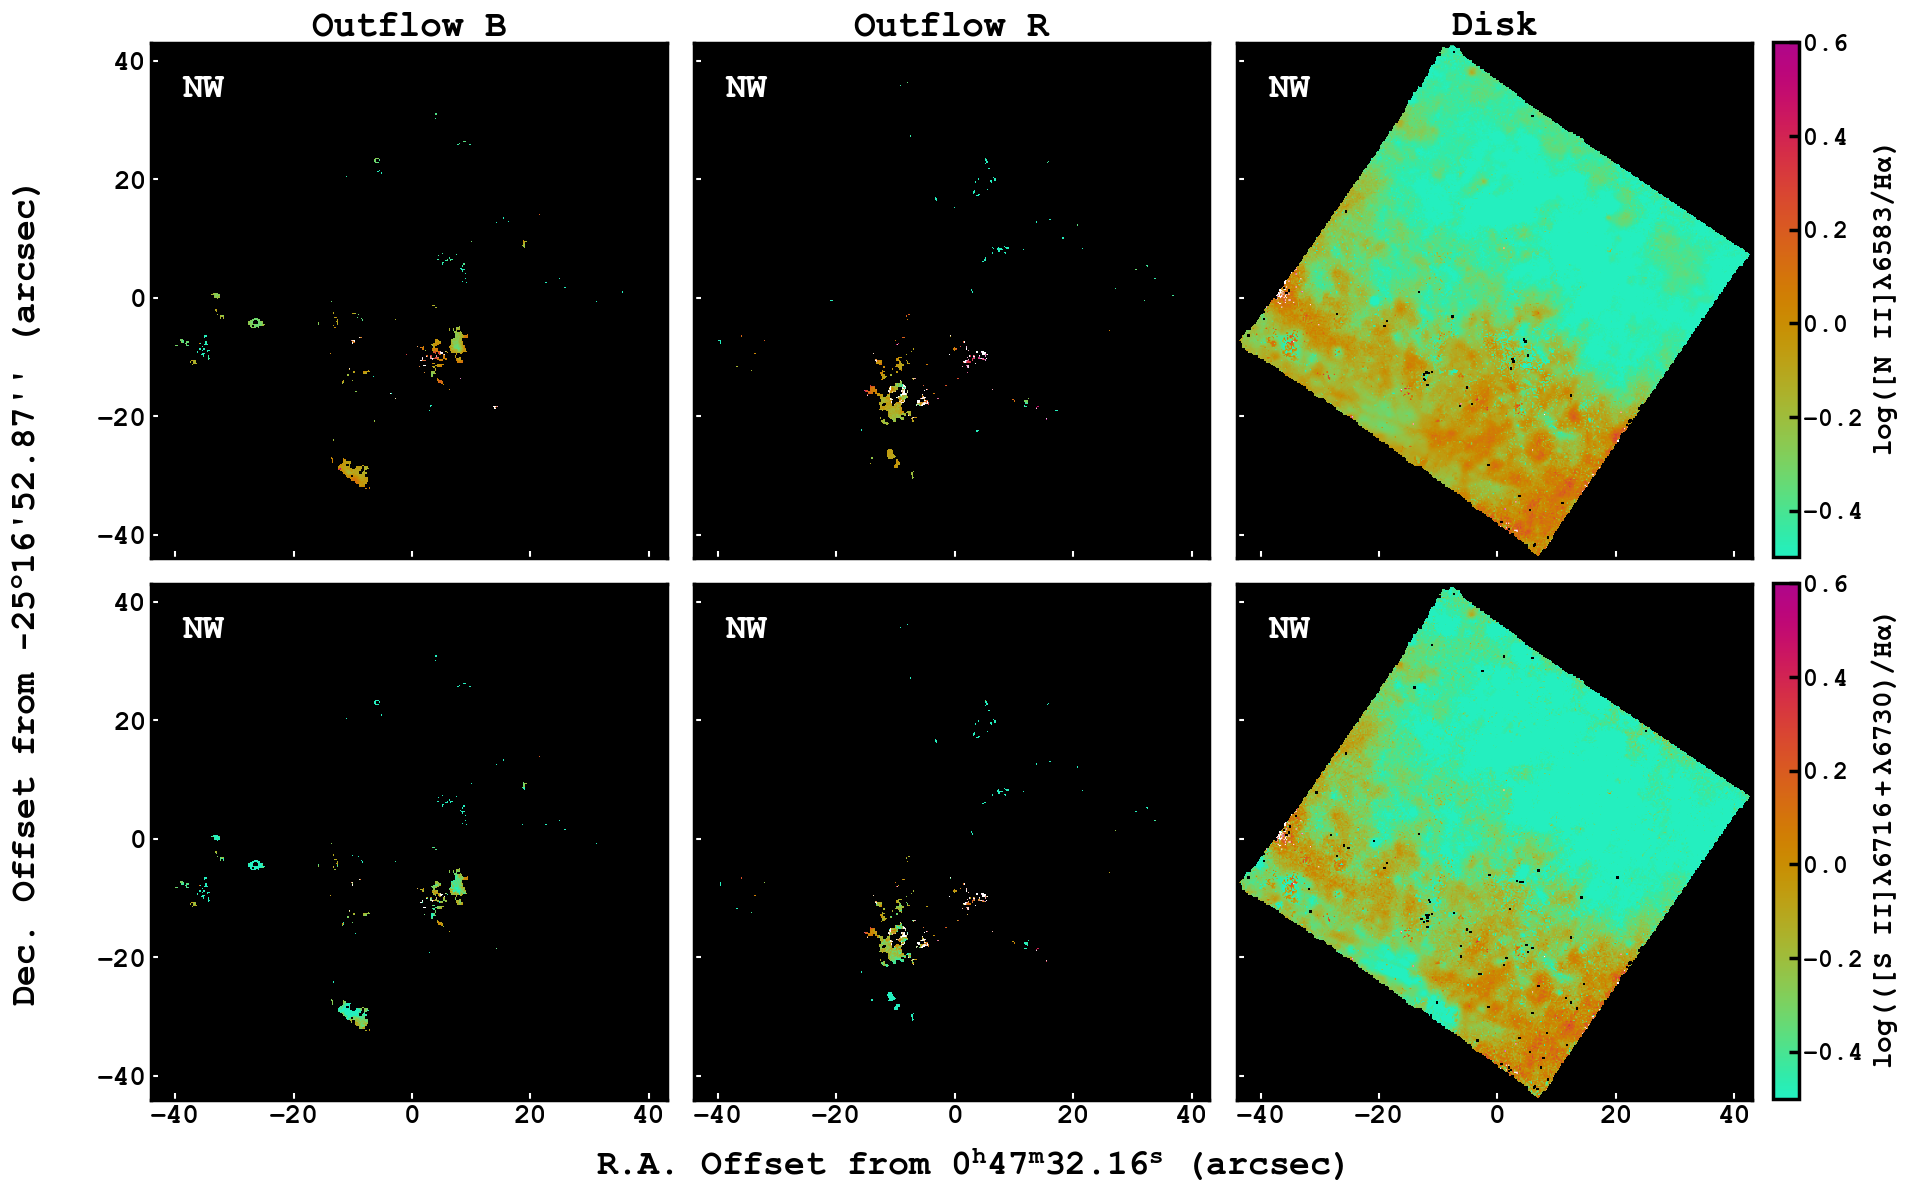

In [9]:
fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

# top row
make_big_plot([ax1, ax2, ax3],
              nii_outb_rat,
              nii_outr_rat,
              nii_disk_rat,
              vmin = -0.5,
              vmax = 0.6,
              titles = True,
              line_label = None,
              cbar_label = 'log([N II]$\lambda 6583$/H$\\alpha$)',
              extent = extent_full,
              alpha_outb = alpha_SNR_ha_outb,
              alpha_outr = alpha_SNR_ha_outr,
              alpha_disk = alpha_SNR_ha_disk)

make_big_plot([ax4, ax5, ax6],
              sii_outb_rat,
              sii_outr_rat,
              sii_disk_rat,
              vmin = -0.5,
              vmax = 0.6,
              titles = False,
              line_label = None,
              cbar_label = 'log(([S II]$\lambda6716+\lambda6730$)/H$\\alpha$)',
              extent = extent_full,
              alpha_outb = alpha_SNR_ha_outb,
              alpha_outr = alpha_SNR_ha_outr,
              alpha_disk = alpha_SNR_ha_disk)


fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2,hspace=0.05)
plt.savefig('../../ngc253/muse/visuals/NW/nw_line_ratios.png',bbox_inches='tight', dpi=200)
plt.savefig('../../ngc253/muse/visuals/NW/nw_line_ratios.pdf',bbox_inches='tight', dpi=200)
plt.show()

In [10]:
print('Outflow B median NII/Ha:', np.median(nii_outb_rat[np.isfinite(nii_outb_rat)]))
print('Outflow R median NII/Ha:', np.median(nii_outr_rat[np.isfinite(nii_outr_rat)]))
print('Disk median NII/Ha:', np.median(nii_disk_rat[np.isfinite(nii_disk_rat)]))

print('Outflow B median SII/Ha:', np.median(sii_outb_rat[np.isfinite(sii_outb_rat)]))
print('Outflow R median SII/Ha:', np.median(sii_outr_rat[np.isfinite(sii_outr_rat)]))
print('Disk median SII/Ha:', np.median(sii_disk_rat[np.isfinite(sii_disk_rat)]))

Outflow B median NII/Ha: -0.18510210286501572
Outflow R median NII/Ha: -0.1533482900804513
Disk median NII/Ha: -0.36880911067235994
Outflow B median SII/Ha: -0.35148925975440237
Outflow R median SII/Ha: -0.26953087705126555
Disk median SII/Ha: -0.3840465538637591


In [11]:
# import pyneb

# set up atoms
# sii = pyneb.Atom('S',2)

# sii_outb_flux_rat = siib_flux_outb / siia_flux_outb
# edens_outb = sii.getTemDen(sii_outb_flux_rat, tem=8000, wave1=6730, wave2=6716)
# np.savetxt('../../ngc253/muse/data/edens_outb_T8000.txt', edens_outb)

# sii_outr_flux_rat = siib_flux_outr / siia_flux_outr
# edens_outr = sii.getTemDen(sii_outr_flux_rat, tem=8000, wave1=6730, wave2=6716)
# np.savetxt('../../ngc253/muse/data/edens_outr_T8000.txt', edens_outr)

# sii_disk_flux_rat = siib_flux_disk / siia_flux_disk
# edens_disk = sii.getTemDen(sii_disk_flux_rat, tem=8000, wave1=6730, wave2=6716)
# np.savetxt('../../ngc253/muse/data/edens_disk_T8000.txt', edens_disk)


In [12]:
# import pyneb

# # set up atoms
# sii = pyneb.Atom('S',2)

# sii_outb_flux_rat = siib_flux_outb / siia_flux_outb
#edens_outb = sii.getTemDen(sii_outb_flux_rat, tem=1e4, wave1=6730, wave2=6716)

# sii_outr_flux_rat = siib_flux_outr / siia_flux_outr
# edens_outr = sii.getTemDen(sii_outr_flux_rat, tem=1e4, wave1=6730, wave2=6716)

# sii_disk_flux_rat = siib_flux_disk / siia_flux_disk
# edens_disk = sii.getTemDen(sii_disk_flux_rat, tem=1e4, wave1=6730, wave2=6716)

# import pyneb
# from multiprocessing import Process
# import sys
# sys.path.append('../../astro_tools')
# from calc_edens import run_outb, run_outr, run_disk

# p1 = Process(target = run_outb, args=(siib_flux_outb,siia_flux_outb))
# p1.start()
# p2 = Process(target = run_outr, args=(siib_flux_outr,siia_flux_outr))
# p2.start()
# p3 = Process(target = run_disk, args=(siib_flux_disk,siia_flux_disk))
# p3.start()

# p1.join()
# p2.join()
# p3.join()

In [13]:
# edens_outb = np.loadtxt('../../ngc253/muse/data/edens_outb.txt')
# edens_outr = np.loadtxt('../../ngc253/muse/data/edens_outr.txt')
# edens_disk = np.loadtxt('../../ngc253/muse/data/edens_disk.txt')


# fig, ((ax1, ax2, ax3),
#      (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

# # top row
# make_big_plot([ax1, ax2, ax3],
#               1/sii_outb_flux_rat,
#               1/sii_outr_flux_rat,
#               1/sii_disk_flux_rat,
#               vmin = 0.8,
#               vmax = 2,
#               titles = True,
#               line_label = None,
#               cbar_label = '[S II]$\lambda6716/[S II]\lambda6730$',
#               extent=extent_full,
#               alpha_outb = alpha_SNR_sii_outb,
#               alpha_outr = alpha_SNR_sii_outr,
#               alpha_disk = alpha_SNR_sii_disk)

# make_big_plot([ax4, ax5, ax6],
#               np.log10(edens_outb),
#               np.log10(edens_outr),
#               np.log10(edens_disk),
#               vmin = 2,
#               vmax = 3.5,
#               titles = False,
#               line_label = None,
#               cbar_label = 'log(n$_{e}$) (cm$^{-3}$)',
#               extent = extent_full,
#               alpha_outb = alpha_SNR_sii_outb,
#               alpha_outr = alpha_SNR_sii_outr,
#               alpha_disk = alpha_SNR_sii_disk)


# fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
# fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
# plt.tight_layout()
# plt.subplots_adjust(wspace=-0.2)

# plt.savefig('../../ngc253/muse/visuals/edensity_full.png',bbox_inches='tight', dpi=200)
# plt.savefig('../../ngc253/muse/visuals/edensity_full.pdf',bbox_inches='tight', dpi=200)
# plt.show()

In [14]:
# # let's zoom in on the nuclear region

# fig, ((ax1, ax2, ax3),
#      (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12))

# # top row
# make_big_plot_diff_axes([ax1, ax2, ax3],
#               1/sii_outb_flux_rat,
#               1/sii_outr_flux_rat,
#               1/sii_disk_flux_rat,
#               vmin = 0.8,
#               vmax = 2,
#               titles = True,
#               line_label = None,
#               cbar_label = '[S II]$\lambda6716/[S II]\lambda6730$',
#               extent = extent_full,
#             extent_label = [-40, -20, 0, 20, 40],
#               alpha_outb = alpha_SNR_sii_outb,
#               alpha_outr = alpha_SNR_sii_outr,
#               alpha_disk = alpha_SNR_sii_disk)

# rect = patches.Rectangle(xy=(5, 5), width=20, height=20, linewidth=3, edgecolor='cyan', facecolor='none')
# ax1.add_patch(rect)
# rect = patches.Rectangle(xy=(5, 5), width=20, height=20, linewidth=3, edgecolor='cyan', facecolor='none')
# ax2.add_patch(rect)
# rect = patches.Rectangle(xy=(5, 5), width=20, height=20, linewidth=3, edgecolor='cyan', facecolor='none')
# ax3.add_patch(rect)


# pixscale = 0.2  # arcsec
# x_lower = ((250-218)*pixscale)
# x_upper = ((350-218)*pixscale)
# y_lower = ((250-218)*pixscale)
# y_upper = ((350-218)*pixscale)
# extent_zoom=[x_lower,x_upper, y_lower,y_upper]


# make_big_plot_diff_axes([ax4, ax5, ax6],
#               np.log10(edens_outb[250:350,250:350]),
#               np.log10(edens_outr[250:350,250:350]),
#               np.log10(edens_disk[250:350,250:350]),
#               vmin = 2,
#               vmax = 3.5,
#               titles = False,
#               line_label = None,
#               cbar_label = 'log(n$_{e}$) (cm$^{-3}$)',
#               extent = extent_zoom,
#             extent_label=[7, 13, 19, 25],
#               alpha_outb = alpha_SNR_sii_outb,
#               alpha_outr = alpha_SNR_sii_outr,
#               alpha_disk = alpha_SNR_sii_disk)


# fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
# fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
# plt.tight_layout()
# plt.subplots_adjust(wspace=-0.2)

# plt.savefig('../../ngc253/muse/visuals/edensity.png',bbox_inches='tight', dpi=200)
# plt.savefig('../../ngc253/muse/visuals/edensity.pdf',bbox_inches='tight', dpi=200)
# plt.show()